# Hybrid model: linear reservoir
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 27-09-2024<br>

* [x] Check the values of residence time ($T$) generated by the LSTM+dense layers.
* [x] Check if the model weights are equal across epochs, which would indicate that the model is not learning. <font color='blue'>They are the same indeed, so the model is not learning.</font>. **FIXED** There were two issues in `LinearReservoir.forward()`:
    * `torch.clamp()` does not do the same as `torch.min(torch.max())`
    * `eps = torch.tensor(..., requires_grad=True, ...)` 
* [ ] Check if the gradients are too small. The inflow/outflow values are very, very small, which could cause small gradients.
* [ ] ¿What's the effect of the <font color='blue'>**warmup period**</font>? Should it be only one day less than the sequence length?
* [ ] Test the best initial value for the initial fraction filled.
* [ ] Try the manual run with several basins in the test sample.
* [ ] Train on storage instead of outflow. Storage needs to be the only variable in `out` (`LinearReservoir.forward()`)
* [ ] Train on both storage and outflow. Storage needs to be added as the second variable in `out` (`LinearReservoir.forward()`)
* [ ] To clip or not to clip gradients?

The fitted residence time varies a lot (probably too much) with time!! Reduce the influence of dynamic inputs? Add static inputs that define the hydroclimatic charateristics of the basin.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf

from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo import get_model
from neuralhydrology.evaluation.plots import boxplot_performance, map_results, boxplot_parameters, lineplot_timeseries

In [19]:
from typing import List

def KGE(obs: pd.Series, sim: pd.Series, sa: float = 1, sb: float = 1, sr: float = 1) -> List[float]:
    """It computes the Kling-Gupta efficiency coefficient.
    
    Parameters:
    -----------
    obs:   pd.Series.
        Observed time series
    sim:   pd.Series
        Simulated time series
    sa, sb, sr: float
        Scale factors of the three terms of the modified KGE: ratio of the coefficient of variation (alpha), bias (beta), and coefficient of correlation (r), respectively
    
    Returns:
    -------
    KGE: float
        Modified KGE
    alpha: float
        Ratio of the standard deviations
    beta: float
        Bias, i.e., ratio of the mean values
    r: float
        Coefficient of correlation
    """
    
    # Eliminar pasos sin dato
    data = pd.concat((obs, sim), axis=1)
    data.columns = ['obs', 'sim']
    data.dropna(axis=0, how='any', inplace=True)
    # Para la función si no hay datos
    assert data.shape[0] > 0, "ERROR. No indices match between the observed and the simulated series."
    
    # calcular cada uno de los términos del KGE
    alpha = data.sim.std() / data.obs.std()
    beta = data.sim.mean() / data.obs.mean()
    r = np.corrcoef(data.obs, data.sim)[0, 1]
    
    # Cacular KGE
    ED = np.sqrt((sr * (r - 1))**2 + (sa * (alpha - 1))**2 + (sb * (beta - 1))**2)
    KGE = 1 - ED
    
    return KGE, alpha, beta, r

In [3]:
def ECDF(series: pd.Series, plot: bool = True, **kwargs) -> pd.Series:
    """it computes the empirical cumulative distribution function (ECDF) of the input data. If specified, the ECDF is plotted.

    Parametres:
    -----------
    series:     pd.Series. 
        Input data
    plot:      bool
        Whether to plot or not the ECMWF

    Output:
    -------
    ecdf:      pd.Series
        The ECDF, where the index represents the non-exceedance probability and the values are those of the input data in ascending order
        
    Keyword arguments:
    ------------------
    lw:        float
        Line width for the line plot
    c:         str
        Line colour for the line plot
    xlim:      Tuple (2,)
        Limits of the X axis in the plot
    ylim:      Tuple (2,)
        Limits of the Y axis in the plot
    ylabel:    str
        Lable of the Y axis in the plot
    title:     str
        Text to be added as the plot title.
    """
    
    if series.isnull().sum() > 0:
        print('WARNING: there are NaN in the input time series')
        data = series.dropna()
    else:
        data = series
        
    ecdf = pd.Series(data=data.sort_values().values,
                     index=np.arange(1, data.shape[0] + 1) / data.count(),
                     name='ECDF')

    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(ecdf.index, ecdf, lw=kwargs.get('lw', 1), c=kwargs.get('c', 'steelblue'))
        ax.set(ylim=kwargs.get('ylim', (-1.02, 1.02)), ylabel=kwargs.get('ylabel', series.name),
               xlim=(-.02, 1.02), xlabel='ECDF (-)',
               title=kwargs.get('title', ''));

    return ecdf


def ECDF_AUC(series: pd.Series) -> float:
    """
    This function computes the area under the ECDF curve.

    Parameters:
    -----------
    series: pd.Series
        Input data

    Output:
    -------
    auc : float
        The area under the ECDF curve.
    """
    
    ecdf = ECDF(series, plot=False)
    auc = np.trapz(ecdf.values, ecdf.index)
    
    return auc

In [4]:
def evaluate(cfg, model, dataloader):
    """It runs the hybrid model step by step for a single basin and puts out the input of the conceptual model, the model parameters, internal states and target variable
    
    Taken from `HybridModel.forward()`
    
    Parameters:
    -----------
    cfg: Config
    model: HybridModel
    dataloader: 
    
    Returns:
    --------
    pred: Dict[str, torch.Tensor]
    """
    
    model.eval()
    predictions = []
    inflow = []
    # obs = []
    with torch.no_grad():
        for data in dataloader:

            # run the LSTM
            # concatenate dynamic and static variables
            x_s_expanded = data['x_s'].unsqueeze(1).expand(-1, data['x_d'].size(1), -1)
            x_concatenated = torch.cat((data['x_d'], x_s_expanded), dim=2).to(cfg.device)
            lstm_output, _ = model.lstm(x_concatenated)

            # run the FC
            linear_output = model.linear(lstm_output[:, cfg.warmup_period:, :])

            # run conceptual model
            x_conceptual = data['x_d_c'][:, cfg.warmup_period:, :]
            pred = model.conceptual_model(x_conceptual=x_conceptual.to(cfg.device),
                                          lstm_out=linear_output)
            inflow.append(x_conceptual)
            predictions.append(pred)
    
    pred = {
        'inflow': torch.cat(inflow, dim=0),
        'storage': torch.cat([pred['internal_states']['ff'] for pred in predictions], dim=0).detach().cpu(),
        'parameters': torch.cat([pred['parameters']['T'] for pred in predictions], dim=0).detach().cpu()
    }
    if cfg.target_variables[0].split('_')[0] == 'outflow':
        pred['outflow'] = torch.cat([pred['y_hat'] for pred in predictions], dim=0).detach().cpu()
    
    return pred

## Configuration

In [47]:
MODEL_PATH = Path('/eos/jeodpp/home/users/casadje/models/ResOpsUS/hybrid_model/')
run_dir = MODEL_PATH / 'linear_reservoir' / 'storage' / 'benchmark_kge_2709_130023' # 'benchmark_2709_092431'

# read configuration file
cfg = Config(run_dir / 'config.yml')

## Data

### Attributes

In [48]:
# load list of reservoirs
reservoirs = sorted(pd.read_csv(cfg.test_basin_file, header=None)[0].tolist())

# load attributes
attributes = pd.concat([pd.read_csv(file, index_col='GRAND_ID') for file in (cfg.data_dir / 'attributes').glob('*.csv')], 
                       axis=1,
                       join='outer')
attributes.index.name = 'id'
attributes = attributes.loc[reservoirs, cfg.static_attributes]

print('no. reservoirs in the attribute tables:', attributes.shape[0])

no. reservoirs in the attribute tables: 118


### Time series

In [49]:
# load time series
dynamic_vars = cfg.dynamic_inputs + cfg.dynamic_conceptual_inputs + cfg.target_variables 
if 'storage_norm' not in cfg.target_variables:
    dynamic_vars += ['storage_norm']
if 'outflow_norm' not in cfg.target_variables:
    dynamic_vars += ['outflow_norm']
timeseries = {ID: xr.open_dataset(cfg.data_dir / 'time_series' / f'{ID}.nc').to_pandas()[dynamic_vars] for ID in reservoirs}
# trim time series to the test period
with open(cfg.per_basin_test_periods_file, 'rb') as file:
    periods = pickle.load(file)
periods = {ID: dct for ID, dct in periods.items() if int(ID) in reservoirs}
for ID, ts in timeseries.items():
    start, end = [periods[str(ID)][x][0] for x in ['start_dates', 'end_dates']]
    ts = ts.loc[start:end]

# # plot time series
# for ID, ts in timeseries.items():
#     start, end = [ls[0] for key, ls in periods[str(ID)].items()]
#     fig, ax = plt.subplots(nrows=2, figsize=(15, 6), sharex=True)
#     ts.loc[start:end, ['inflow_norm', 'outflow_norm']].plot(ax=ax[0], lw=.8);
#     ts.loc[start:end, ['storage_norm']].plot(ax=ax[1], lw=.8)
#     ax[0].set_title(ID)
#     ax[1].set(ylim=(-.02, 1.02),
#               ylabel='storage (-)',
#               );
#     plt.savefig(cfg.data_dir / 'plots' / f'{ID:04}.jpg')

## Results

### Performance

best epoch:	2
KGE train:	0.492
KGE validation:	0.228


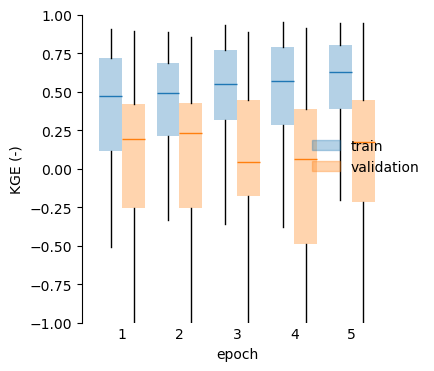

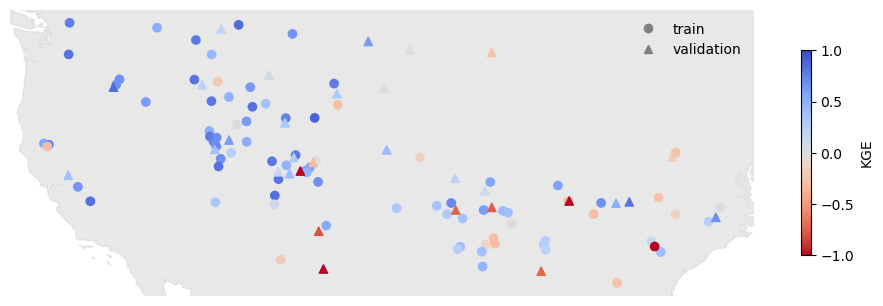

In [52]:
metric = cfg.metrics[0]

# performance of each reservoir, sample and epoch
performance = {sample: [] for sample in ['train', 'validation']}#, 'test']}
for sample, perf_list in performance.items():
    for epoch in range(1, cfg.epochs + 1):
        try:
            aux = pd.read_csv(run_dir / sample / f'model_epoch{epoch:03}' / f'{sample}_metrics.csv',
                              index_col='basin').squeeze()
            aux.name = epoch
            perf_list.append(aux)
        except Exception as e:
            print(e)
performance = {sample: pd.concat(perf_list, axis=1) for sample, perf_list in performance.items()}

# best epoch
best_epoch = performance['validation'].median(axis=0).idxmax()
# best_epoch = performance['validation'].apply(ECDF_AUC).idxmax()
print(f'best epoch:\t{best_epoch}')
for sample, df in performance.items():
    print('{0} {1}:\t{2:.3f}'.format(metric, sample, df[best_epoch].median()))
    # print('{0} {1}:\t{2:.3f}'.format(metric, sample, ECDF_AUC(df[best_epoch])))

# define sample and performance of each reservoir
for sample, df in performance.items():
    attributes.loc[df.index, 'sample'] = sample
    attributes.loc[df.index, metric] = df[best_epoch]

# add performance to the attributes
cols = [f'{metric}_{sample}' for sample in performance.keys()]
if len(attributes.columns.intersection(cols)) == 0:
    attributes = pd.concat((attributes, pd.DataFrame({f'{metric}_{sample}': df[best_epoch] for sample, df in performance.items()})), axis=1)

# boxplot performance
boxplot_performance(cfg, performance, save=run_dir / 'performance_boxplot.jpg')

# map performance
map_results(
    attributes.LON,
    attributes.LAT,
    attributes[metric],
    attributes['sample'],
    save=run_dir / f'performance_map_epoch{best_epoch:03}'
)

### Evaluate

I run the evaluation on all the reservoirs to extract not only the target variables, but also the parameters of the conceptual model.

In [53]:
# get the hybrid model: LSTM + LinearReservoir
model = get_model(cfg).to(cfg.device)
print(model)
print('device:', next(model.parameters()).device)

# load model states
weights = torch.load(run_dir / f'model_epoch{best_epoch:03}.pt',)
model.load_state_dict(weights)

# load scaler
scaler = load_scaler(run_dir)

# evaluate
results = {sample: {} for sample in ['train', 'validation']}
for sample, results_sample in results.items():
    # load sample data
    dataset = get_dataset(cfg,
                          is_train=False,
                          period=sample,
                          scaler=scaler)
    basins = [int(basin) for basin in dataset.basins]

    # run evaluation basin per basin
    pbar = tqdm(dataset.basins, desc=f'# {sample}')
    for basin in pbar:
        # load dataset
        ds = get_dataset(cfg=cfg,
                         is_train=False,
                         period=sample,
                         basin=basin,
                         # additional_features=self.additional_features,
                         # id_to_int=self.id_to_int,
                         scaler=scaler)

        # setup data loader
        loader = DataLoader(ds,
                            batch_size=cfg.batch_size,
                            num_workers=0,
                            collate_fn=ds.collate_fn)
        
        # evaluate
        results_sample[basin] = evaluate(cfg, model, loader)

# convert results to pandas.DataFrame
results_df = {sample: {} for sample in results}
for sample, results_sample in results.items():
    for basin, dct in results_sample.items():
        # define date index
        start, end = [periods[basin][f'{x}_dates'][0] for x in ['start', 'end']]
        dates = pd.date_range(start, end, freq='1D')
        
        # concatenate time series
        results_df[sample][basin] = pd.concat((
            pd.Series(dct['inflow'].numpy()[:, -1, 0], index=dates, name='inflow'),
            pd.Series(dct['parameters'].numpy()[:, -1], index=dates, name='T'),
            pd.Series(dct['storage'].numpy()[:, -1], index=dates, name='storage'),
            # pd.Series(results[basin]['outflow'].numpy()[:, -1, 0], index=dates, name='outflow'),
        ),
            axis=1
        )
        if 'outflow' in dct:
            results_df[sample][basin] = pd.concat((
                results_df[sample][basin],
                pd.Series(dct['outflow'].numpy()[:, -1, 0], index=dates, name='outflow'),
            ),
            axis=1
        )

HybridModel(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(28, 256)
  (conceptual_model): LinearReservoirV()
  (linear): Linear(in_features=256, out_features=1, bias=True)
)
device: cuda:0


# train: 100% 85/85 [02:05<00:00,  1.48s/it]
# validation: 100% 33/33 [00:44<00:00,  1.36s/it]


#### Parameters

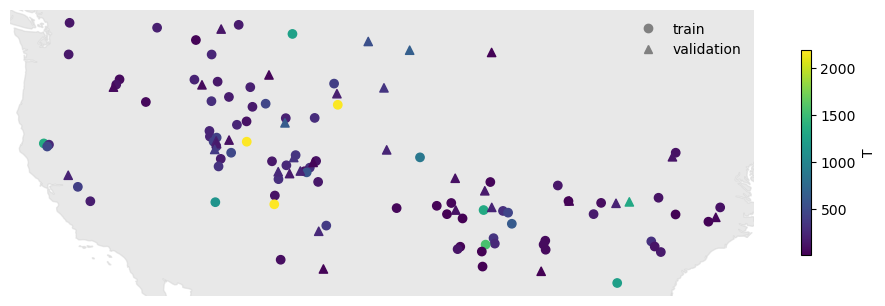

In [54]:
# add the median of the estimated parameter to the attributes table
attributes['T'] = pd.Series({int(basin): df['T'].median(skipna=True) for sample, dct in results_df.items() for basin, df in dct.items()}, name='T')

# export median value
PATH_OUT = run_dir / sample / f'model_epoch{best_epoch:03}'
for sample in attributes['sample']:
    mask = attributes['sample'] == sample
    attributes[mask][['T']].to_csv(run_dir / sample / f'model_epoch{best_epoch:03}' / f'{sample}_parameters.csv')

# map fitted parameter
map_results(
    attributes.LON,
    attributes.LAT,
    attributes['T'],
    attributes['sample'],
    clim=model.conceptual_model.parameter_ranges['T'],
    cmap='viridis',
    save=run_dir / f'parameter_map_epoch{best_epoch:03}.jpg'
)

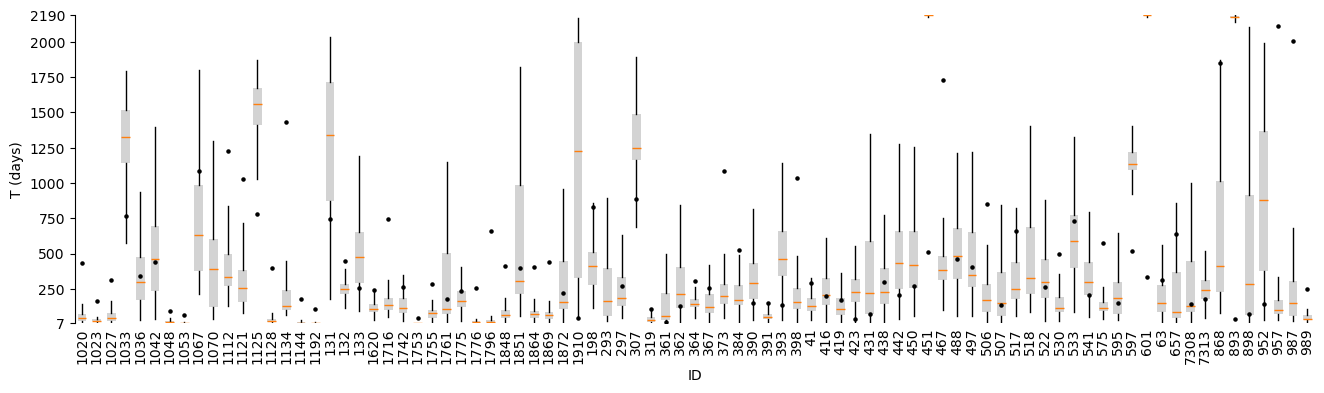

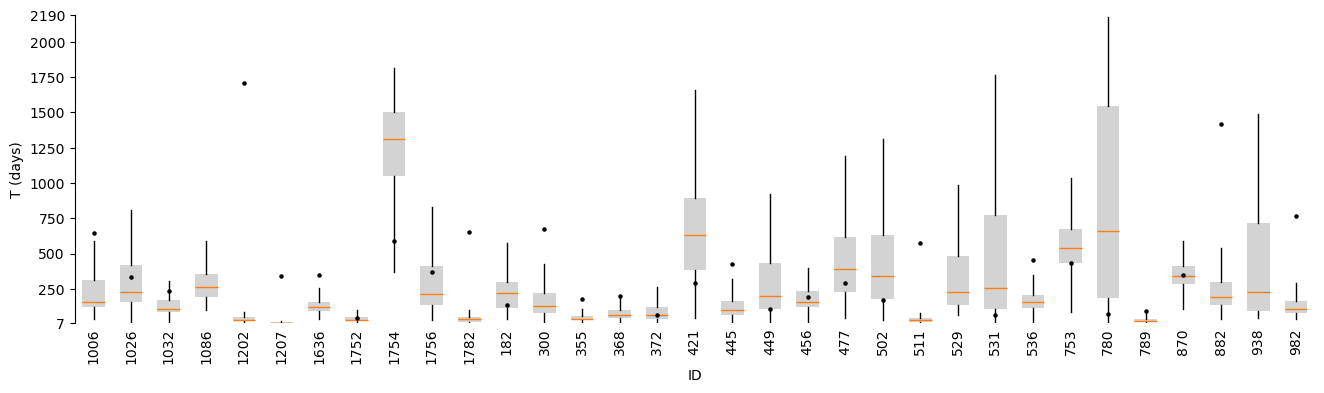

In [55]:
# boxplot of simulated parameters
for sample, dct in results_df.items():
    path_out = run_dir / sample / f'model_epoch{best_epoch:03}' / 'plots'
    path_out.mkdir(parents=True, exist_ok=True)
    boxplot_parameters(
        dct,
        'T',
        attributes['DOR_PC'] * 3.65,
        ylabel='T (days)',
        ylim=model.conceptual_model.parameter_ranges['T'],
        save=path_out / 'parameters_boxplot.jpg'
    )

#### Time series

In [56]:
# plot simulated vs observed timeseries
for sample, dct in results_df.items():
    path_out = run_dir / sample / f'model_epoch{best_epoch:03}' / 'plots'
    path_out.mkdir(parents=True, exist_ok=True)
    for ID, df in dct.items():
        lineplot_timeseries(
            cfg,
            sim=df,
            obs=timeseries[int(ID)],
            xlim=[periods[str(ID)][f'{dt}_dates'][0] for dt in ['start', 'end']],
            ylim=model.conceptual_model.parameter_ranges['T'],
            title=ID,
            save=path_out / f'{ID}.jpg'
        )

***

In [25]:
target = cfg.target_variables[0]
results_df['validation']['1006'][target.split('_')[0]]

1982-01-01         NaN
1982-01-02         NaN
1982-01-03         NaN
1982-01-04         NaN
1982-01-05         NaN
                ...   
2014-11-26    0.691796
2014-11-27    0.687409
2014-11-28    0.681963
2014-11-29    0.676651
2014-11-30    0.671323
Freq: D, Name: storage, Length: 12022, dtype: float32

In [26]:
timeseries[1006][cfg.target_variables[0]]

date
1982-01-01    0.543658
1982-01-02    0.543658
1982-01-03    0.547264
1982-01-04    0.547563
1982-01-05    0.546514
                ...   
2019-12-26    0.553922
2019-12-27    0.553184
2019-12-28    0.553390
2019-12-29    0.555942
2019-12-30    0.558486
Name: storage_norm, Length: 13878, dtype: float64

In [30]:
performance['validation'].loc[1006]

1    0.121223
2    0.444760
3    0.134346
4    0.383877
5    0.527379
Name: 1006, dtype: float64

In [31]:
best_epoch

2

In [28]:
kge, alpha, beta, r = KGE(obs=timeseries[1006][cfg.target_variables[0]],
                          sim=results_df['validation']['1006'][target.split('_')[0]])
kge, alpha, beta, r

(-2.5460263839290564,
 4.436549019385937,
 1.278554037575792,
 0.17124092703080304)

***

In [57]:
sample = 'train'
ID = performance[sample][best_epoch].idxmax()
# ID = 300 #445 # 372 # 1032

ID, performance[sample][best_epoch].max()

(898, 0.8854718675756948)

#### Parameters

(13521, 365)


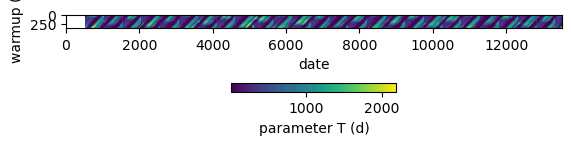

In [58]:
par = results[sample][str(ID)]['parameters'].numpy()
print(par.shape)

vmin, vmax = model.conceptual_model.parameter_ranges['T']
fig, ax = plt.subplots()#figsize=(15, 3))
im = ax.imshow(np.transpose(par), vmin=vmin, vmax=vmax)
ax.set(
    xlabel='date',
    ylabel='warmup (d)'
)
# ax.set_xticklabels([dt.date() for dt in dates[::1000]])
fig.colorbar(im, shrink=.333, label='parameter T (d)', orientation='horizontal');#, pad=.35);

In [68]:
model.conceptual_model.device

AttributeError: 'LinearReservoirV' object has no attribute 'device'

In [72]:
# fractin filled, i.e., normalised storage
ff = torch.tensor(0.65,
                  dtype=torch.float32,
                  device='cuda'
                 )#.repeat(x_conceptual.shape[0])
print(ff.shape)

# storage limits
FFc = torch.tensor(0.1,
                   dtype=torch.float32,
                   device='cuda',
                   requires_grad=False)
print(FFc.shape)

if ff < FFc:
    print('hola')
else:
    print('adiós')

torch.Size([])
torch.Size([])
adiós


In [82]:
FF = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32, device='cuda', requires_grad=True)

In [86]:
# Create an empty tensor with the same shape as FF
zeros = torch.zeros_like(FF, requires_grad=FF.requires_grad)

In [87]:
zeros.dtype, zeros.device, zeros.requires_grad

(torch.float32, device(type='cuda', index=0), True)

#### Outflow

In [ ]:
if 'outflow' in results[sample][str(ID)]:
    out = results[sample][str(ID)]['outflow'].numpy()[:,:,0]
    print(out.shape)

    im = plt.imshow(np.transpose(out), vmin=0)
    plt.colorbar(im, shrink=.333, label='outflow (-)', orientation='horizontal');

#### Storage

In [ ]:
state = results[sample][str(ID)]['storage'].numpy()
print(state.shape)
im = plt.imshow(np.transpose(state), vmin=0, vmax=1)
plt.colorbar(im, shrink=.333, label='storage (-)', orientation='horizontal');

In [ ]:
dates = pd.date_range(*[periods[str(ID)][f'{dt}_dates'][0] for dt in ['start', 'end']])

fig, ax = plt.subplots(nrows=3, figsize=(15, 6), sharex=True)
lw = .3
for n, i in enumerate(np.linspace(0, state.shape[1] - 1, 3)):
    # c = 'k' if i == out.shape[1] - 1 else f'C{n}'
    c = f'C{abs(2 - n)}'
    if 'outflow_norm' in cfg.target_variables:
        ax[0].plot(pd.Series(out[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')
    ax[1].plot(pd.Series(state[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')
    ax[2].plot(pd.Series(par[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')

# observed
ax[0].plot(timeseries[int(ID)].loc[dates, 'outflow_norm'], lw=lw*(n+1), c='k', zorder=0, label='obs')
ax[1].plot(timeseries[int(ID)].loc[dates, 'storage_norm'], lw=lw*(n+1), c='k', zorder=0, label='obs')
    
ax[0].set(xlim=(dates[0], dates[-1]),
          ylim=(0, None),
          ylabel='outflow (-)')
ax[1].set(ylim=(-.05, 1.05),
          ylabel='storage (-)')
ax[2].set(ylim=model.conceptual_model.parameter_ranges['T'],
          ylabel='T (days)')
ax[-1].set_xlabel('date')

# ax[-1].set_xlim((pd.Timestamp(2000, 1, 1), pd.Timestamp(2001, 1, 1)))

fig.legend(*ax[1].get_legend_handles_labels(), frameon=False, loc=5, bbox_to_anchor=[.9, .33, .15, .33]);